## Import Libraries
Dependencies include python time library, numpy, matplotlib, scipy, pandas and sklearn

In [32]:
# import libraries
from time import time
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import cross_val_score

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Help Functions for Classification

In [4]:
def read_subject_sleep(id):
###
# read csv files of subjects in and output sleeps, epochs and heartrate
###
    sleepLabelled_fname = "../sleepLabelled/sleepLabelled_{}.csv".format(id)
    
    sleep = pd.read_csv(sleepLabelled_fname)
    
    return sleep

In [9]:
def read_all_subjects_sleep():
    # define subject ids here to read all the files
    studyIds = ["CRP{0:03d}".format(i+1) for i in range(60)]
    studyIds.remove("CRP013")
    
    all_sleeps = []
    
    for s_id in studyIds:
        sleep = read_subject_sleep(s_id)
        all_sleeps.append(sleep)
    
    return all_sleeps

In [21]:
def plot_roc_curve(clf, X_test, y_test):
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label= str(type(clf).__name__)+' (area = {0:0.2f})'.format(lr_auc ) )
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve', pad= 20.0, fontdict= {'fontsize':15})
    # show the legend
    plt.legend()
    plt.show()

In [22]:
def plot_precision_recall_curve(clf, X_test, y_test):  
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = clf.predict_proba(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
    # summarize scores
    print('f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Effect')
    pyplot.plot(lr_recall, lr_precision, marker='.', label= str(type(clf).__name__) + '(area = {0:0.2f})'.format(lr_auc ))
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve', pad= 20.0, fontdict= {'fontsize':15})
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

### Read all subject files
Perform test and training split

In [10]:
dir_sleep_labelled = "../sleepLabelled/"
dir_aggregate = "../aggregateData/"

# read in all subjects labelled sleep csv files
all_sleeps = read_all_subjects_sleep()
# concatenate all sleep periods
sleep_dataset = pd.concat(all_sleeps, ignore_index=True, sort=False)
# feature transform
colnames = list(sleep_dataset.columns.values)
y = sleep_dataset["sleepLabel"].copy()
X = sleep_dataset.drop(colnames[0:60]+['sleepLabel', 
                                       'steps', 
                                       'distanceInMeters', 
                                       'studyId', 
                                       'startDateTime'],axis = 1).copy()
X['HRstd'] = X['HRstd']**2
X = sklearn.preprocessing.normalize(X, axis = 0)
y[y<0]=0
y = y.to_numpy()
y=y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

### Trying models


Training Accuracy
0.9443717454064701
Testing Accuracy
0.943718972587956
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     17637
           1       0.93      0.96      0.95     19427

    accuracy                           0.94     37064
   macro avg       0.94      0.94      0.94     37064
weighted avg       0.94      0.94      0.94     37064



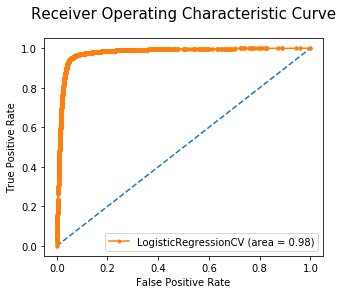

In [25]:
from sklearn.linear_model import LogisticRegressionCV
lg = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)
print("Training Accuracy")
print(lg.score(X_train, y_train))
y_pred = lg.predict(X_test)
print("Testing Accuracy")
print(lg.score(X_test, y_test))
print(classification_report(y_test, y_pred))
plot_roc_curve(lg, X_test, y_test)

In [29]:
# ridge regression
from sklearn.linear_model import RidgeClassifierCV
rgcv = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10]).fit(X_train, y_train)
rgcv.score(X, y)
print("Training Accuracy")
print(rgcv.score(X_train, y_train))
y_pred = rgcv.predict(X_test)
print("Testing Accuracy")
print(rgcv.score(X_test, y_test))
print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_pred)

Training Accuracy
0.9287699322774735
Testing Accuracy
0.9250215842866393
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     17637
           1       0.89      0.98      0.93     19427

    accuracy                           0.93     37064
   macro avg       0.93      0.92      0.92     37064
weighted avg       0.93      0.93      0.92     37064



0.9224705762489145

In [33]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=6, random_state=0).fit(X,y)
rf.score(X, y)
print("Training Accuracy")
print(rf.score(X_train, y_train))
y_pred = rf.predict(X_test)
print("Testing Accuracy")
print(rf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
scores = cross_val_score(rf, X, y, cv=5)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Training Accuracy
0.9475285324987184
Testing Accuracy
0.9467677530757609
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     17637
           1       0.94      0.96      0.95     19427

    accuracy                           0.95     37064
   macro avg       0.95      0.95      0.95     37064
weighted avg       0.95      0.95      0.95     37064

CV Accuracy: 0.94 (+/- 0.05)


In [23]:
def random_forest_nested_CV(clf, X_train, y_train):
    # Number of random trials
    NUM_TRIALS = 1

    # Set up possible values of parameters to optimize over
    p_grid = {"max_depth": [3, 5, 7],
              "n_estimators": [10, 100]}

    # Arrays to store scores
    non_nested_scores = np.zeros(NUM_TRIALS)
    nested_scores = np.zeros(NUM_TRIALS)

    # Loop for each trial
    for i in range(NUM_TRIALS):

        # Choose cross-validation techniques for the inner and outer loops,
        # independently of the dataset.
        # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=rfc, param_grid=p_grid, cv=inner_cv)
        clf.fit(X_train, y_train)
        non_nested_scores[i] = clf.best_score_

        # Nested CV with parameter optimization
        nested_score = cross_val_score(clf, X=X_train, y=y_train, cv=outer_cv)
        nested_scores[i] = nested_score.mean()
    print("None nested scores:")    
    print(non_nested_scores)
    print("Nested scores:")
    print(nested_scores)


None nested scores:
[0.94796698]
Nested scores:
[0.94798721]


In [36]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier
adab = AdaBoostClassifier(n_estimators=25, random_state=0).fit(X_train, y_train)
print("Training Accuracy")
print(adab.score(X_train, y_train))
y_pred = adab.predict(X_test)
print("Testing Accuracy")
print(adab.score(X_test, y_test))
print(classification_report(y_test, y_pred))
scores = cross_val_score(adab, X, y, cv=5)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Training Accuracy
0.941963683457896
Testing Accuracy
0.9413986617742284
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     17637
           1       0.93      0.96      0.94     19427

    accuracy                           0.94     37064
   macro avg       0.94      0.94      0.94     37064
weighted avg       0.94      0.94      0.94     37064

CV Accuracy: 0.85 (+/- 0.36)


In [38]:
from sklearn import svm
svc = svm.SVC(kernel='rbf').fit(X_train, y_train)
print("Training Accuracy")
print(svc.score(X_train, y_train))
y_pred = svc.predict(X_test)
print("Testing Accuracy")
print(svc.score(X_test, y_test))
print(classification_report(y_test, y_pred))
scores = cross_val_score(svc, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Training Accuracy
0.9470631087607587
Testing Accuracy
0.9464170084178718
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     17637
           1       0.94      0.96      0.95     19427

    accuracy                           0.95     37064
   macro avg       0.95      0.95      0.95     37064
weighted avg       0.95      0.95      0.95     37064

Accuracy: 0.95 (+/- 0.03)


# Predict on all other epochs based on feature engineering

In [46]:
def read_all_aggregate():
    studyIds = ["CRP{0:03d}".format(i+1) for i in range(60)]
    studyIds.remove("CRP013")
    
    all_aggregates= []
    
    for s_id in studyIds:
        a = pd.read_csv("../aggregateData/aggregate_fe_{}.csv".format(s_id))
        all_aggregates.append(a)
    
    return all_aggregates

In [47]:
def feature_transform(aggre):
    colnames = list(aggre.columns.values)
    X = aggre.copy().drop(colnames[0:60]+['sleepLabel', 'steps', 'distanceInMeters', 'studyId', 'startDateTime'],axis = 1)
    X['HRstd'] = X['HRstd']**2
    X = sklearn.preprocessing.normalize(X, axis = 0)
    return X

In [48]:
def predict_sleep(clf, aggre):
    aggre_fe = feature_transform(aggre)
    y_pred = clf.predict(aggre_fe)
    studyId = aggre['studyId'][0]
    aggre['predictedSleep'] = y_pred
    aggre.to_csv("../aggregateData/aggregate_fe_predlabel_{}.csv".format(studyId))

In [49]:
all_aggregates = read_all_aggregate()

In [50]:
for aggregate in all_aggregates:
    predict_sleep(clf, aggregate)